In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

In [120]:
# загрузим данные
# !unzip tabular-playground-series-apr-2021.zip
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
print(train.shape, test.shape)

(100000, 12) (100000, 11)


# Context

Набор данных является синтетическим. Статистические свойства этого набора данных очень похожи на исходный набор данных Титаника.
Данные разбиты на две группы: тренировочный набор (train.csv) набор тестов (test.csv).

Используются следующие переменные:

0. PassengerId - id пассажира
1. survival	- выживание (0 = No, 1 = Yes);
2. pclass - класс билета (1 = 1st, 2 = 2nd, 3 = 3rd)
3. sex - пол	
4. Age - возраст (год)	
5. sibsp - количество братьев и сестер / супругов на борту Титаника
6. parch - количество родителей/детей на борту Титаника	
7. ticket - номер билета
8. fare	- тариф
9. cabin - номер каюты
10. embarked - порт посадки (C = Cherbourg, Q = Queenstown, S = Southampton)

In [100]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [101]:
print(train.shape, test.shape)

(100000, 12) (100000, 11)


# Data quality assessment

In [102]:
# количество пропущенных значений
train.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64

In [103]:
# доля пропущенных значенийъ
null_sum = dict(train.isnull().sum())
for feature in train:
    print(feature, round(null_sum[feature] / train.shape[0], 3))

PassengerId 0.0
Survived 0.0
Pclass 0.0
Name 0.0
Sex 0.0
Age 0.033
SibSp 0.0
Parch 0.0
Ticket 0.046
Fare 0.001
Cabin 0.679
Embarked 0.002


In [104]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Очень много данных пропущено в колонке Cabin: больше 68%. Также пропуски имеют: Age, Ticket, Fare, Embarked.

In [121]:
# столбик Cabin можно полностью удалить,
# а также удалить строки, где пропущены знаечния из каких-либо других столбцов (Age, Ticket, Fare, Embarked)
train = train.dropna(axis='index', how='any', subset=['Age', 'Ticket', 'Fare', 'Embarked'])
train.drop('Cabin', axis=1, inplace=True)

# train.Age.fillna(train.Age.mean(), inplace=True)
# train.Fare.fillna(train.Fare.mean(), inplace=True)

In [106]:
# количество строк сократилось
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91880 entries, 2 to 99999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  91880 non-null  int64  
 1   Survived     91880 non-null  int64  
 2   Pclass       91880 non-null  int64  
 3   Name         91880 non-null  object 
 4   Sex          91880 non-null  object 
 5   Age          91880 non-null  float64
 6   SibSp        91880 non-null  int64  
 7   Parch        91880 non-null  int64  
 8   Ticket       91880 non-null  object 
 9   Fare         91880 non-null  float64
 10  Embarked     91880 non-null  object 
dtypes: float64(2), int64(5), object(4)
memory usage: 8.4+ MB


In [108]:
100000 - train.shape[0]

8120

Количество записей стало меньше на 8120

In [109]:
ticket_group = dict(train.groupby('Ticket', as_index=True).count().PassengerId)
ticket_group = dict(sorted(ticket_group.items(), reverse=True, key=lambda x: x[1]))
df_tickets = pd.DataFrame({'Name': ticket_group.keys(), 'Num': ticket_group.values()})
df_tickets.head(10)

,Name,Num
0,A/5,575
1,C.A.,172
2,SC/PARIS,141
3,SOTON/O.Q.,76
4,SC,54
5,W./C.,52
6,A/5.,37
7,W.E.P.,23
8,CA,22
9,STON/O2.,20


Есть много номеров билетов, которые повторяются по несколько раз для разных пассажиров.

# Data exploration

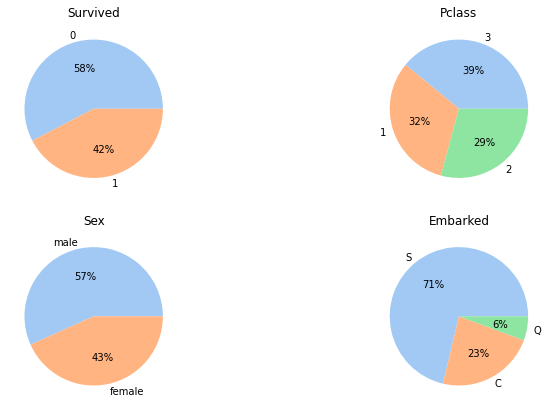

In [117]:
colors = sns.color_palette('pastel')
plt.figure(figsize=(12, 7))

for n, i in enumerate(['Survived', 'Pclass', 'Sex', 'Embarked']):
    plt.subplot(2, 2, n+1)
    cur_dict = dict(train[i].value_counts(dropna=True))
    plt.title(i)
    plt.pie(cur_dict.values(), labels = cur_dict.keys(), colors = colors, autopct='%.0f%%')

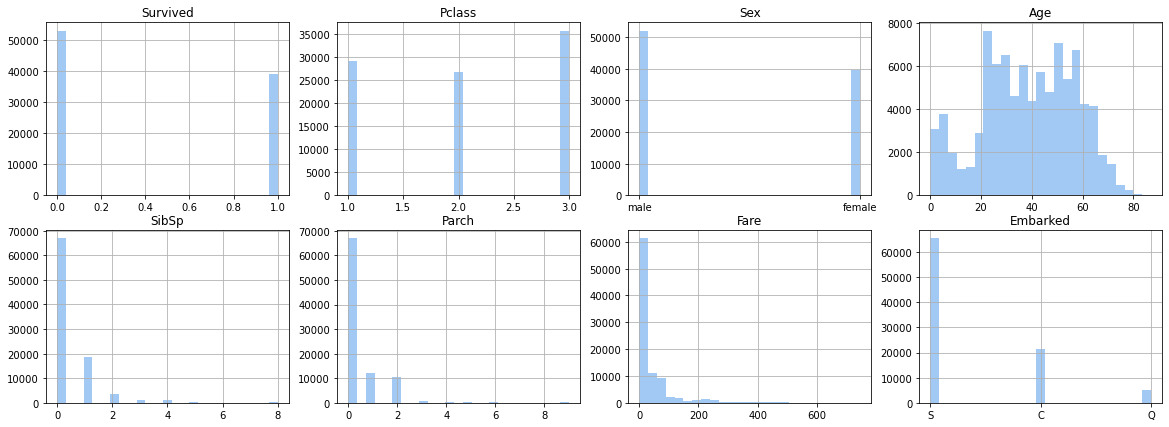

In [123]:
plt.figure(figsize=(20, 7))
for n, i in enumerate(train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)):
# for n, i in enumerate(train.drop(['PassengerId', 'Name', 'Ticket', 'Sex_0_1'], axis=1)):
    plt.subplot(2, 4, n+1)
    plt.title(i)
    plt.hist(train[i], bins=25, color=colors[0])
    plt.grid(True)

По графику Survived (0 = No, 1 = Yes) видно, что большая часть людей не выжила.

По графику Pclass можно определить, что у большинства пассажиров был 3 класс, 1 и 2 класс - примерно одинаковое количество пассажиров.

По графику Sex - мужчин было больше, чем женцин.

По графику Age видно, что наибольшему количеству людей от 20 до 60 лет, также можно определить меры центральной тенденции:

In [132]:
print('Максимальный возраст =', train['Age'].max())
print('Минимальный возраст =', train['Age'].min())
print('Средний возраст =', train['Age'].mean())
print('Мода возраста =', *list(train['Age'].mode()))
print('Медиана возраста =', train['Age'].median())

Максимальный возраст = 87.0
Минимальный возраст = 0.08
Средний возраст = 38.516881584675644
Мода возраста = 23.0
Медиана возраста = 39.0


По графику SibSp видно, что у большинства пассадиров количество братьев и сестер / супругов на борту равно 0.

Такие же выводы можно сделать по графику Parch о количестве родителей/детей на борту.

График Fare имеет распределение похожее на лог-логистическое, т.к. имеет тяжелый хвост. Также обладает следующими мерами центральной тенденции:

In [134]:
print('Максимальный тариф =', train['Fare'].max())
print('Минимальный тариф =', train['Fare'].min())
print('Средний тариф =', train['Fare'].mean())
print('Мода тарифа =', *list(train['Fare'].mode()))
print('Медиана тарифа =', train['Fare'].median())

Максимальный тариф = 744.66
Минимальный тариф = 0.68
Средний тариф = 45.40469721375702
Мода тарифа = 9.85
Медиана тарифа = 25.16


По графику Embarked (C = Cherbourg, Q = Queenstown, S = Southampton) видно, что большинство пассажиров сели в порту Southampton.

In [124]:
# применим LabelEncoder к полу и порту посадки пассажиров
le_Sex = preprocessing.LabelEncoder()
train['Sex_0_1'] = le_Sex.fit_transform(train.Sex)

le_Embarked = preprocessing.LabelEncoder()
train.Embarked = le_Embarked.fit_transform(train.Embarked)

In [126]:
le_Embarked.inverse_transform([0, 1, 2])

array(['C', 'Q', 'S'], dtype=object)

In [125]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_0_1
count,91880.000000,91880.000000,91880.000000,91880.000000,91880.000000,91880.000000,91880.000000,91880.000000,91880.000000
mean,50031.776828,0.423520,2.072312,38.516882,0.394384,0.465596,45.404697,1.482216,0.567185
std,28878.673832,0.494119,0.838325,18.303124,0.850912,0.962805,70.774805,0.843305,0.495468
min,2.000000,0.000000,1.000000,0.080000,0.000000,0.000000,0.680000,0.000000,0.000000
25%,25001.750000,0.000000,1.000000,25.000000,0.000000,0.000000,10.230000,1.000000,0.000000
50%,50056.500000,0.000000,2.000000,39.000000,0.000000,0.000000,25.160000,2.000000,1.000000
75%,75050.250000,1.000000,3.000000,53.000000,1.000000,1.000000,34.432500,2.000000,1.000000
max,99999.000000,1.000000,3.000000,87.000000,8.000000,9.000000,744.660000,2.000000,1.000000


In [135]:
# посчитаем корреляцию между числовыми данными
train_corr = train.corr()
t = {abs(train_corr[row][col]):tuple((row, col)) for row in train_corr.index for col in train_corr.index if row != col}


top_correlated_features = sorted(t.items(), reverse=True, key=lambda x: x[0])[:10]

In [136]:
# посмотрим на корреляцию между числовыми данными
train.corr().style.background_gradient()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_0_1
PassengerId,1.000000,0.001967,0.000324,-0.002547,0.000916,-0.000145,-0.001974,-0.002592,-0.001068
Survived,0.001967,1.000000,-0.308358,0.108288,-0.006773,0.028008,0.197613,-0.386401,-0.512802
Pclass,0.000324,-0.308358,1.000000,-0.261693,-0.058822,-0.031775,-0.410294,0.329553,0.217320
Age,-0.002547,0.108288,-0.261693,1.000000,-0.114982,-0.131481,0.108064,-0.143585,-0.084812
SibSp,0.000916,-0.006773,-0.058822,-0.114982,1.000000,0.218294,0.062697,0.026489,-0.028772
Parch,-0.000145,0.028008,-0.031775,-0.131481,0.218294,1.000000,0.056186,-0.006953,-0.093330
Fare,-0.001974,0.197613,-0.410294,0.108064,0.062697,0.056186,1.000000,-0.233388,-0.153842
Embarked,-0.002592,-0.386401,0.329553,-0.143585,0.026489,-0.006953,-0.233388,1.000000,0.345750
Sex_0_1,-0.001068,-0.512802,0.217320,-0.084812,-0.028772,-0.093330,-0.153842,0.345750,1.000000


По таблице видно, что корреляция наиболее выражана между презнаками (топ 10):

In [137]:
top_correlated_features

[(0.5128021804951168, ('Sex_0_1', 'Survived')),
 (0.4102935634244217, ('Fare', 'Pclass')),
 (0.38640058199208277, ('Embarked', 'Survived')),
 (0.3457495625685225, ('Sex_0_1', 'Embarked')),
 (0.32955308287035356, ('Embarked', 'Pclass')),
 (0.30835779628560483, ('Pclass', 'Survived')),
 (0.26169284803543946, ('Age', 'Pclass')),
 (0.23338783374020416, ('Embarked', 'Fare')),
 (0.21829401567869214, ('Parch', 'SibSp')),
 (0.21731991234462095, ('Sex_0_1', 'Pclass'))]

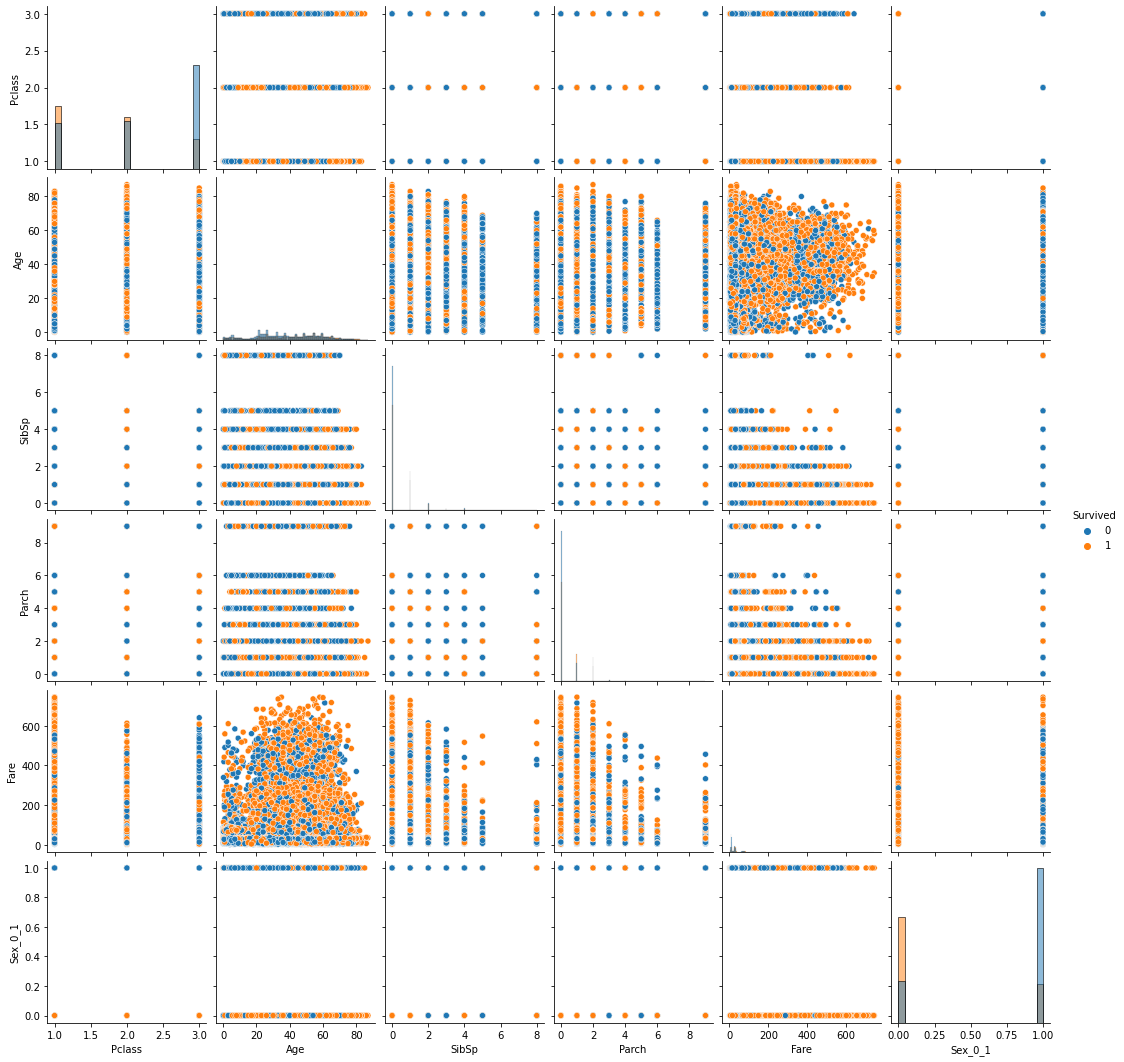

In [181]:
# посмотрим, как Survived влияет на другие фичи
sns.pairplot(train.drop('PassengerId', axis=1), hue='Survived', diag_kind="hist");

Можно заметить, что значение пола влияет на то выживет ли пассажир, а также Pclass. Еще можно заметить, что почти все пассажиры с самыми дорогимими тарифами выжили вне зависимости от возраста. А самые дорогие тарифы у пассажиров 1 класса. Рассмотрим подробнее взаимосвязи переменных ниже.

In [151]:
train.Embarked = le_Embarked.inverse_transform(train.Embarked)

<AxesSubplot:xlabel='Sex'>

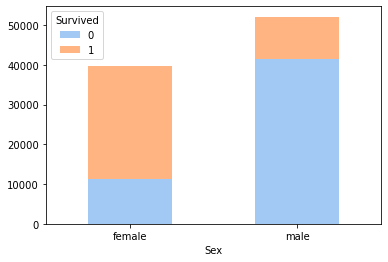

In [139]:
# посмотрим чуть более подробнее на зависимость Sex от Survived
grouped_by_sex = train.groupby(["Sex"])["Survived"].value_counts()
grouped_by_sex.unstack().plot.bar(stacked=True, rot=0, color=colors)

По графику видно, что выживших женщин больше.

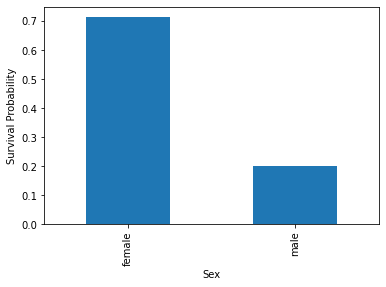

In [140]:
# посмотрим как Sex влияет на вероятность того, что пассажир выживет
plot = train[['Sex', 'Survived']].groupby('Sex').mean().Survived.plot(kind='bar')
plot.set_xlabel('Sex')
plot.set_ylabel('Survival Probability');

По графику видно, что вероятность того, что пассажир женщина виживет, значительно выше, чем если пассажир явяется мужчиной. То есть признак Sex действительно сильно влияет на Survived.

<AxesSubplot:xlabel='Pclass'>

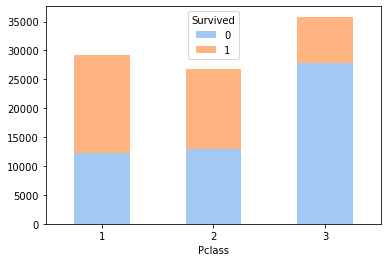

In [141]:
# посмотрим чуть более подробнее на зависимость Pclass от Survived
grouped_by_Pclass = train.groupby(["Pclass"])["Survived"].value_counts()
grouped_by_Pclass.unstack().plot.bar(stacked=True, rot=0, color=colors)

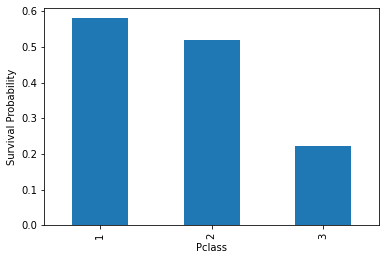

In [142]:
# посмотрим как Pclass влияет на вероятность того, что пассажир выживет
plot = train[['Pclass', 'Survived']].groupby('Pclass').mean().Survived.plot(kind='bar')
plot.set_xlabel('Pclass')
plot.set_ylabel('Survival Probability');

По графикам видно, что вероятность выживания пассажиров 1 и 2 классов выше, чем у 3 класса.

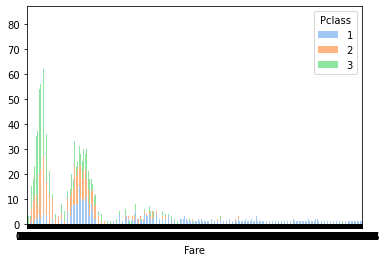

In [143]:
# посмотрим как связаны Fare и Pclass
grouped_by_Fare_Pclass = train.groupby(["Fare"])["Pclass"].value_counts()
grouped_by_Fare_Pclass.unstack().plot.bar(stacked=True, rot=0, color=colors);

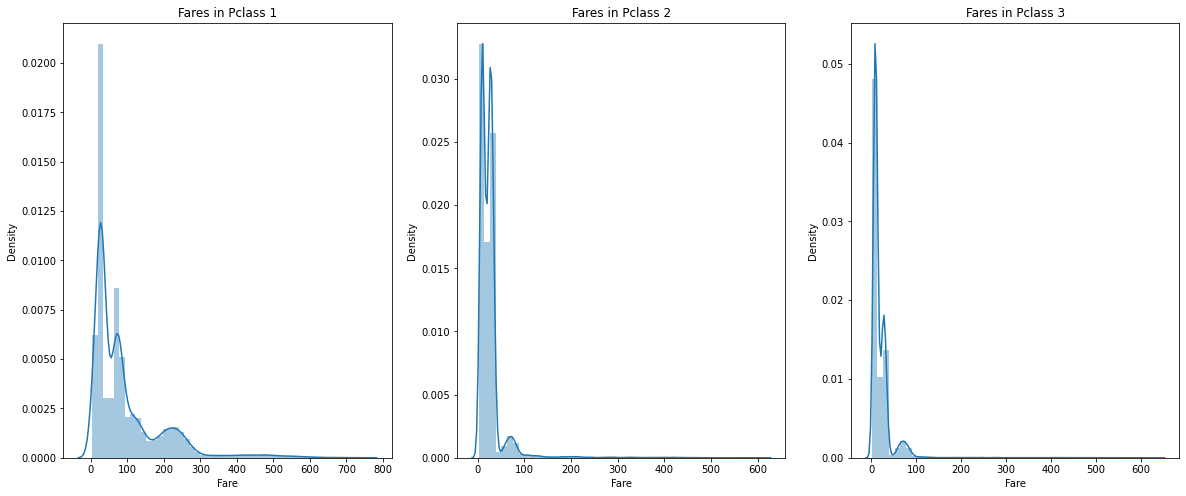

In [144]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(train[train['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(train[train['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(train[train['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show();

Pclass со значением 1 имеет более высокие значения Fare по сравнению с 1 и 2. 3 Pclass имеет самую большую плотность распределения на более дешевых тарифах (небольших значений Fare).

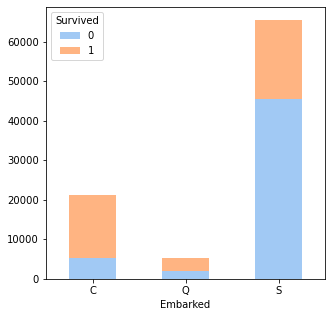

In [188]:
# посмотрим чуть более подробнее на зависимость Embarked от Survived
plt.rcParams['figure.figsize'] = (5, 5)
grouped_by_Embarked = train.groupby(["Embarked"])["Survived"].value_counts()
grouped_by_Embarked.unstack().plot.bar(stacked=True, rot=0, color=colors);

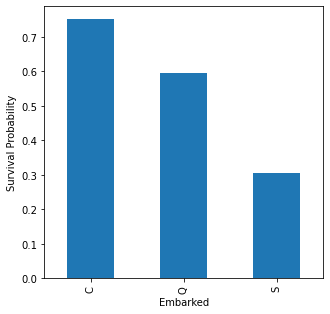

In [187]:
# посмотрим как Embarked влияет на вероятность того, что пассажир выживет
plt.rcParams['figure.figsize'] = (5, 5)
plot = train[['Embarked', 'Survived']].groupby('Embarked', dropna=True).mean().Survived.plot(kind='bar')
plot.set_xlabel('Embarked')
plot.set_ylabel('Survival Probability');

У пассажиров, которые сели в порту S (Southampton) самая низкая вероятность Survived, видно, что большинство пассажиров сели в порту Southampton. В других портах село значительно меньше пассажиров, при этом доля выживших больше, чем у Embarked Southampton.

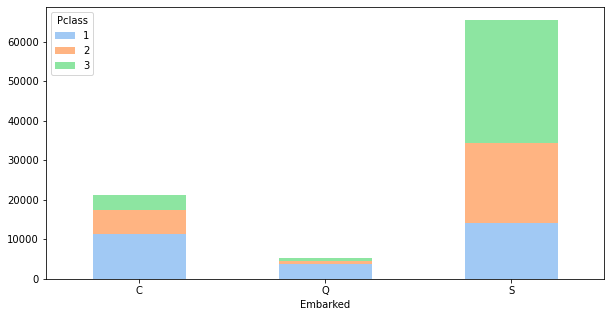

In [208]:
# посмотрим на зависимость Embarked от Pclass
grouped_by_Embarked = train.groupby(["Embarked"])["Pclass"].value_counts()
grouped_by_Embarked.unstack().plot.bar(stacked=True, rot=0, color=colors);

С Embarked = S больше всего пассажиров с Pclass = 3, в остальных Embarked преобладает 1 класс.

In [224]:
le_Embarked = preprocessing.LabelEncoder()
train.Embarked = le_Embarked.fit_transform(train.Embarked)

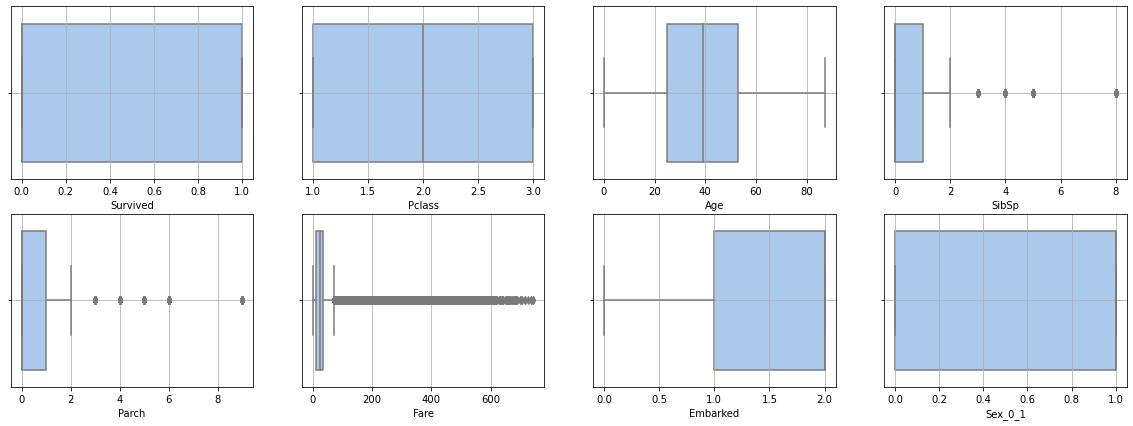

In [222]:
# посмотрим на данные и определим выбросы с помощью boxplot
plt.figure(figsize=(20, 7))
for n, i in enumerate(train.drop(['PassengerId', 'Name', 'Ticket', 'Sex'], axis=1)):
    plt.subplot(2, 4, n+1)
#     plt.title(i)
    sns.boxplot(train[i], color=colors[0])
    plt.grid(True)

Как видно по графикам, выбросы имеют: SibSp, Parch, Fare. Embarked сильно скошен вправо (большинство пассажиров сели в порту S, как уже было описано выше).

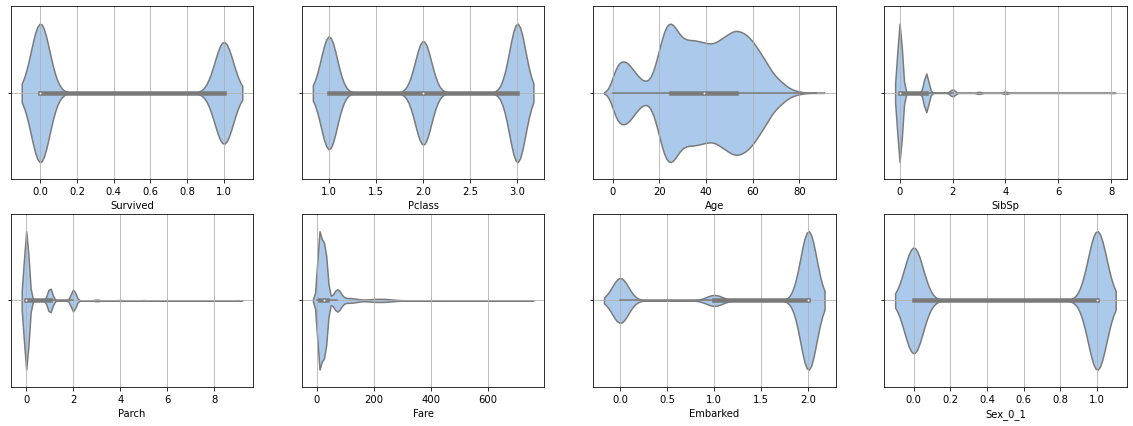

In [225]:
# посмотрим на данные и определим выбросы с помощью violinplot
plt.figure(figsize=(20, 7))
for n, i in enumerate(train.drop(['PassengerId', 'Name', 'Ticket', 'Sex'], axis=1)):
    plt.subplot(2, 4, n+1)
    sns.violinplot(train[i], color=colors[0])
    plt.grid(True)

Данные графики показывают, плотность распределения данных. По ним можно подтвердить выводы, сделанные выше.

In [226]:
train.Embarked = le_Embarked.inverse_transform(train.Embarked)

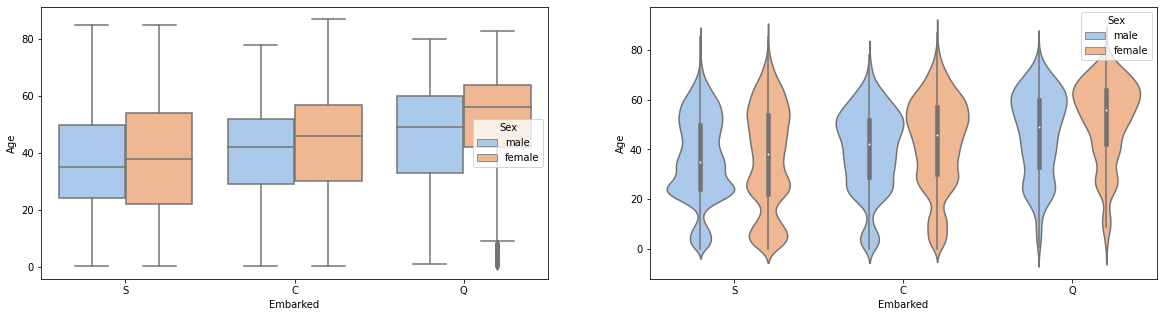

In [240]:
# посмотрим, как взаимосвязаны между сосбой Embarked, Age и Sex
plt.subplot(1, 2, 1)
plt.rcParams['figure.figsize'] = (10, 5)
sns.boxplot(
    x="Embarked",
    y="Age",
    hue="Sex",
    palette=colors,
    data=train
)
plt.subplot(1, 2, 2)
sns.violinplot(x="Embarked", y="Age",
            hue="Sex", palette=colors,
            data=train);

 В зависимотсти от порта посадки женщины в среднем старше мужчин. В порту (Embarked) Q у женщин есть несколько выбросов.

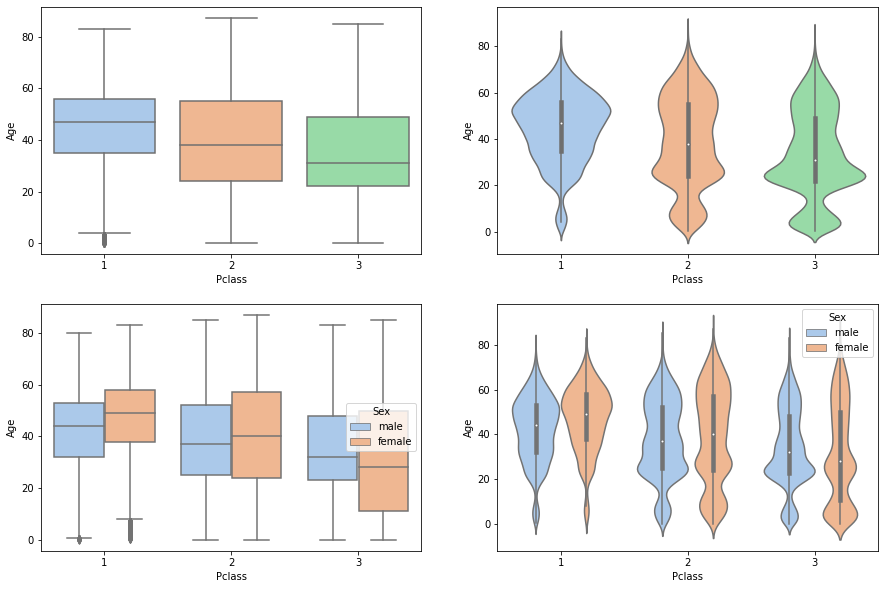

In [254]:
# посмотрим, как взаимосвязаны между сосбой Pclass и Age
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplot(2, 2, 1)
sns.boxplot(
    x="Pclass",
    y="Age",
#     hue="Sex",
    palette=colors,
    data=train
)
plt.subplot(2, 2, 2)
sns.violinplot(x="Pclass", y="Age",
#             hue="Sex",
            palette=colors,
            data=train)

# посмотрим, как взаимосвязаны между сосбой Pclass, Age и Sex
plt.subplot(2, 2, 3)
sns.boxplot(
    x="Pclass",
    y="Age",
    hue="Sex",
    palette=colors,
    data=train
)
plt.subplot(2, 2, 4)
sns.violinplot(x="Pclass", y="Age",
            hue="Sex",
            palette=colors,
            data=train);

В среднем пассажиры 1 класса старше пасажиров других классов, однако есть выбросы.

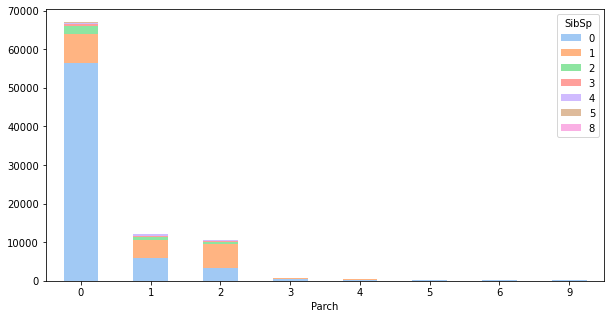

In [258]:
plt.rcParams['figure.figsize'] = (10, 5)
grouped_by_Embarked = train.groupby(["Parch"])["SibSp"].value_counts()
grouped_by_Embarked.unstack().plot.bar(stacked=True, rot=0, color=colors);

По графику видно, что большинство пассажиров на корабле одни: на борту нет братье/сестер, родителей, детей или супругов (Parch и SibSp равны 0), но есть такие, которые путешествуют семей. Например, если Parch (количество родителей или детей) на борту больше 0, то повышается вероятность (доля) того, что SibSp (количество братьев и сетстер или супругов не равно 0), чаще всего в таком случае SibSp = 1.

# Summary

Выжил ли пассажир сильно зависит от его пола: для женщин вероятность выживания выше.

1 класс (Pclass) имеет более дорогие тарифы (Fare). У наибольшего количества пассажиров 3 класс, но вероятность выживания пассажиров 1 и 2 классов выше, чем у 3 класса.

Fare зависит от Pclass, также они взаимосвязаны с Embarked. У пассажиров, которые сели в порту S (Southampton) самая низкая вероятность Survived. С Embarked = S больше всего пассажиров с Pclass = 3, в остальных Embarked преобладает 1 класс.

Также Pclass зависит от возраста пассажира: в среднем пассажиры 1 класса старше пасажиров других классов.

Таким образом, самую большую вероятность выжить (Survived = 1) имеют женщины, у которых очень дорогой тариф (Fare), Pclass = 1, Embarked = C.